In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pylab import rcParams

In [3]:
%matplotlib inline
rcParams['figure.figsize'] = 16, 9

In [4]:
user_df = pd.read_csv('user_data.csv')
user_df['date'] = pd.to_datetime(user_df.date)

In [5]:
user_df.columns

Index(['user', 'orders', 'cost', 'date'], dtype='object')

In [6]:
user_df[['orders', 'cost']].describe()

,orders,cost
count,1.015119e+06,1.015119e+06
mean,1.972975e+00,4.475029e+03
std,9.461065e+00,2.827953e+04
min,1.000000e+00,-1.848000e+02
25%,1.000000e+00,9.303000e+02
50%,1.000000e+00,1.840300e+03
75%,1.000000e+00,3.963050e+03
max,3.183000e+03,1.173418e+07


<h2>Исследуем параметр F</h2>

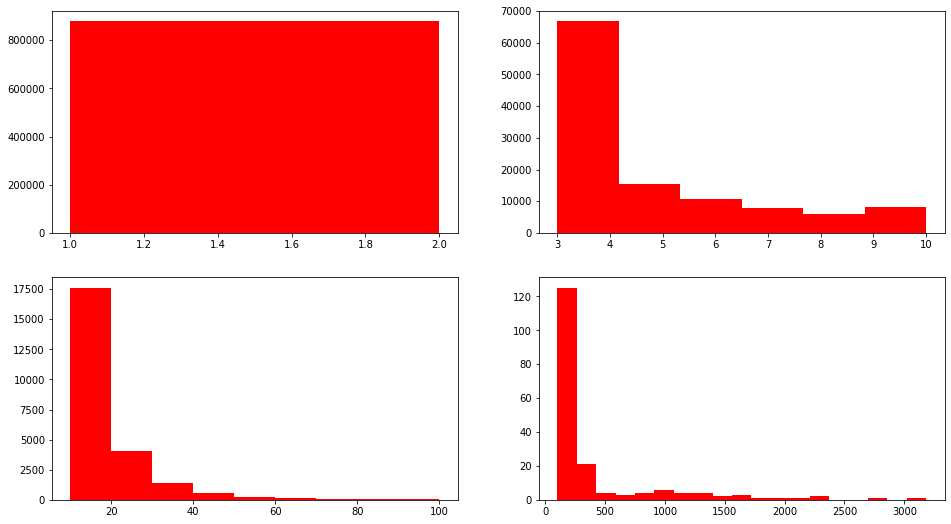

In [7]:
data = user_df['orders']
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0, 0].hist(data, bins=np.linspace(1, 2, 2), color='red')
axes[0, 1].hist(data, bins=np.linspace(3, 10, 7), color='red')
axes[1, 0].hist(data, bins=np.linspace(10, 100, 10), color='red')
axes[1, 1].hist(data, bins=np.linspace(100, data.max(), 20), color='red')
plt.show()

In [8]:
temp = [
    user_df.loc[user_df['orders'] == i, 'orders'].count() for i in range(1, 10)
]
temp

[774497, 105007, 42759, 24046, 15569, 10625, 7775, 5828, 4565]

<b>Принимаем решение о градации F 1 = 1, [2, 5] = 2, [6, max) = 3<b/>

In [9]:
user_df.loc[user_df['orders'] == 1, 'F'] = 1
user_df.loc[user_df['orders'].isin(range(2,6)), 'F'] = 2
user_df.loc[user_df['orders']  >= 6, 'F'] = 3
total = 0
for i in range(1, 4):
    F = user_df.loc[user_df['F'] == i, 'F'].count()
    total += F 
    print('{:<7} со значением F {}'.format(F, i))
total == len(user_df)

774497  со значением F 1
187381  со значением F 2
53241   со значением F 3


True

<h2>Исследуем параметр R</h2>

<b>Принимаем решение<br>
R – 3 для клиентов, которые покупали <= 30 дней<br> 
R – 2 для клиентов, которые покупали > 30 и менее 60 дней<br>
R - 1 для остальных клиентов

In [10]:
max_date = user_df['date'].max()
max_date

Timestamp('2017-12-31 00:00:00')

In [11]:
user_df.loc[user_df['date'] <= max_date - timedelta(60), 'R'] = 1
user_df.loc[(user_df['date'] < max_date - timedelta(30)) & (user_df['date'] >= max_date - timedelta(60)), 'R'] = 2
user_df.loc[user_df['date'] >= max_date - timedelta(30), 'R'] = 3
total = 0
for i in range(1, 4):
    R = user_df.loc[user_df['R'] == i, 'R'].count()
    total += R 
    print('{:<7} со значением F {}'.format(R, i))
total == len(user_df)

788069  со значением F 1
89210   со значением F 2
137840  со значением F 3


True

<h2>Исследуем параметр M</h2>

In [12]:
user_df = user_df.drop(user_df.loc[user_df['cost']<=0,].index.values)

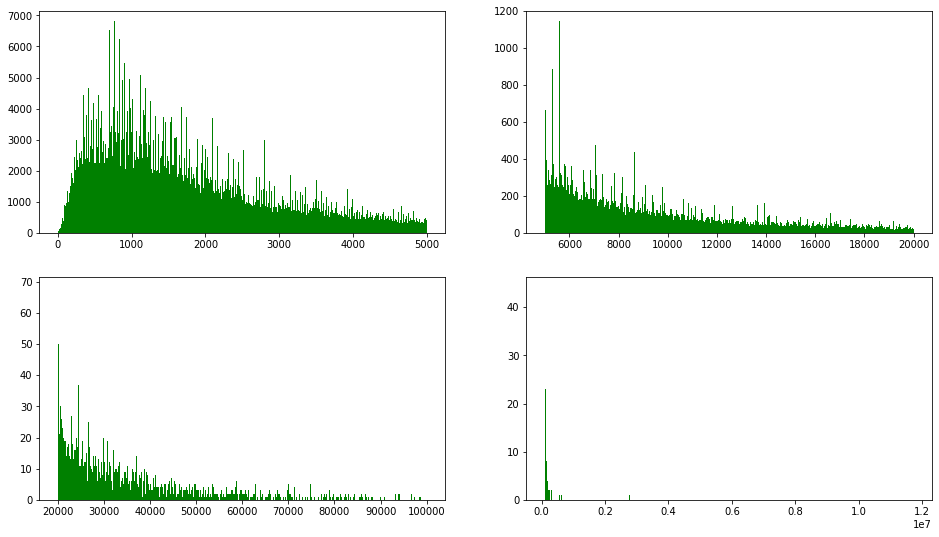

In [12]:
data = user_df['cost']
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0, 0].hist(data, bins=np.linspace(0, 5000, 500), color='green')
axes[0, 1].hist(data, bins=np.linspace(5000, 20000, 1500), color='green')
axes[1, 0].hist(data, bins=np.linspace(20000, 100000, 8000), color='green')
axes[1, 1].hist(data, bins=np.linspace(100000, data.max(), 10000), color='green')
plt.show()

<b>Принимаем решение <br>М = 1 если покупки нe больше 4000
    <br>M = 2 если покупики от 4000 до 10000
        <br>M = 3 если покупики больше 10000

In [13]:
user_df.loc[user_df['cost'] <= 4000, 'M'] = 1
user_df.loc[(user_df['cost'] > 4000) & (user_df['cost'] <= 10000), 'M'] = 2
user_df.loc[user_df['cost'] > 10000, 'M'] = 3
total = 0
for i in range(1, 4):
    M = user_df.loc[user_df['M'] == i, 'M'].count()
    total += M 
    print('{:<7} со значением F {}'.format(M, i))
total == len(user_df)

764038  со значением F 1
158191  со значением F 2
92886   со значением F 3


True

In [14]:
vip_users = user_df['user'][(user_df['F'] == 3) & (user_df['R'] == 3) & (user_df['M'] == 3)]
vip_cost = user_df.loc[user_df['user'].isin(vip_users), 'cost'].sum()
print('Всего VIP пользоватлей: ', vip_users.count())
print('Оборот по VIP: {:0.0f}. Процент от общего оборота {:0.2%}'.format(vip_cost, vip_cost / user_df['cost'].sum()))
vip_users.head()

Всего VIP пользоватлей:  13597
Оборот по VIP: 612283448. Процент от общего оборота 13.48%


22    234
31    302
39    337
60    537
68    721
Name: user, dtype: int64

In [15]:
segs = [(r, f, m) for r in range(1, 4) for f in range(1, 4) for m in range(1, 4)]
total_cost = user_df['cost'].sum()
percent_146 = 0
print('| {:^9s} | {:^15s} | {:^15s} | {:^7s} |'.format('Сегмент', 'Пользователей', 'Оборот', 'Процент'))
for seg in segs:
    users = user_df['user'][(user_df['F'] == seg[0]) & (user_df['R'] == seg[1]) & (user_df['M'] == seg[2])]
    cost = user_df.loc[user_df['user'].isin(users), 'cost'].sum()
    percent_seg = cost / total_cost
    percent_146 += percent_seg
    print('| {:^9s} | {:^15d} | {:^15.0f} | {:^7.2%} |'.format(str(seg), users.count(), cost, percent_seg))
print('{:57.2%}'.format(percent_146))

|  Сегмент  |  Пользователей  |     Оборот      | Процент |
| (1, 1, 1) |     543360      |    777553352    | 17.12%  |
| (1, 1, 2) |      62865      |    371063272    |  8.17%  |
| (1, 1, 3) |      17419      |    295479318    |  6.50%  |
| (1, 2, 1) |      52043      |    79469365     |  1.75%  |
| (1, 2, 2) |      6597       |    38471582     |  0.85%  |
| (1, 2, 3) |      1604       |    27082507     |  0.60%  |
| (1, 3, 1) |      80906      |    123869088    |  2.73%  |
| (1, 3, 2) |      8144       |    46755607     |  1.03%  |
| (1, 3, 3) |      1555       |    26835526     |  0.59%  |
| (2, 1, 1) |      65747      |    146954055    |  3.23%  |
| (2, 1, 2) |      48064      |    301587306    |  6.64%  |
| (2, 1, 3) |      22240      |    422136925    |  9.29%  |
| (2, 2, 1) |      7961       |    19367074     |  0.43%  |
| (2, 2, 2) |      8303       |    52932115     |  1.17%  |
| (2, 2, 3) |      4280       |    81064973     |  1.78%  |
| (2, 3, 1) |      12616      |    30750